In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots an event-level variable (MET) based on conditionals with its associated Jet arrays (in this case, where at least 2 have pT > 40 and abs(eta) < 1)

class JetMETProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET_pt", "MET [GeV]", 50, 0, 200)
        
        self._accumulator = processor.dict_accumulator({
            'MET_pt': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df["dataset"]
        
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content,
            eta=df['Jet_eta'].content,
            phi=df['Jet_phi'].content,
            mass=df['Jet_mass'].content,
            )
        # We can access keys without appealing to a JCA, as well.
        MET = df['MET_pt']
        
        output['cutflow']['all events'] += jets.size
        
        # We want jets with a pt of at least 40.
        pt_min = (jets['p4'].pt > 40)
        
        # We want jets with abs(eta) < 1
        eta_max = (np.abs(jets['p4'].eta) < 1)

        # We want MET where the above conditions are met for at least two jets. The above are a list of Boolean sublists generated from the jet sublists (True if condition met, False if not). If we sum each sublist, we get the amount of jets matching the condition (since True = 1).
        good_MET = MET[(pt_min.sum() >= 2) & (eta_max.sum() >= 2)]
        # We do the same, separately, to keep track of how many events meet the condition. Then we see how many events meet both.
        output['cutflow']['two abs(eta) < 1 jets'] += MET[(eta_max.sum() >= 2)].size
        output['cutflow']['two pt > 40 jets'] += MET[(pt_min.sum() >= 2)].size  
        output['cutflow']['final events'] += good_MET.size
        
        output['MET_pt'].fill(dataset=dataset, MET_pt=good_MET.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'MET Masked by Jet': ["root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv4/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/50000/C9B654CF-0B51-4444-A177-479200DCC429.root"]}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=JetMETProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 500000)

Processing: 100%|██████████| 3/3 [00:14<00:00,  4.67s/items]


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (MET Masked by Jet) instance at 0x7f88700320b8>: [<matplotlib.collections.PolyCollection at 0x7f88dd926978>],
  'legend': <matplotlib.legend.Legend at 0x7f88dd926c50>})

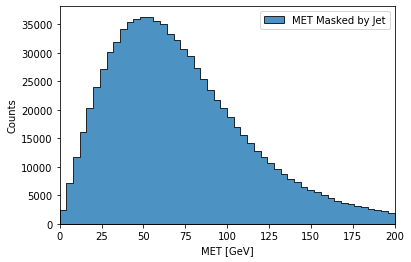

In [4]:
hist.plot1d(output['MET_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 1118000
two abs(eta) < 1 jets 915404
two pt > 40 jets 1061891
final events 876674
